## 2. Problema de Múltiples Anotaciones

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

In [3]:
df = pd.read_csv("./sentiment_polarity/mturk_answers.csv")
df['dif'] = df['Input.true_sent'] == df['Answer.sent']
df['Input.true_sent'] = np.where(df['Input.true_sent'] == 'pos', 1, df['Input.true_sent'])
df['Input.true_sent'] = np.where(df['Input.true_sent'] == 'neg', -1, df['Input.true_sent'])

df['Answer.sent'] = np.where(df['Answer.sent'] == 'pos', 1, df['Answer.sent'])
df['Answer.sent'] = np.where(df['Answer.sent'] == 'neg', -1, df['Answer.sent'])

df.head()

,WorkerId,Input.id,Input.original_sentence,Input.stemmed_sent,Input.true_sent,Answer.sent,dif
0,A2HD5XMM48KKJW,4518,"the cast is phenomenal , especially the women .",cast phenomen especi women,1,1,True
1,A2HD5XMM48KKJW,10415,"the metaphors are provocative , but too often ...",metaphor provoc often viewer left puzzl mechan...,-1,-1,True
2,A2HD5XMM48KKJW,7098,while there's something intrinsically funny ab...,there someth intrins funni sir anthoni hopkin ...,-1,1,False
3,A2HD5XMM48KKJW,4396,a harrowing account of a psychological breakdo...,harrow account psycholog breakdown,1,-1,False
4,A2HD5XMM48KKJW,2812,". . . a visually seductive , unrepentantly tr...",visual seduct unrepentantli trashi rice instal...,1,1,True


Para trabajar el problema se usara la etiqueta 1 para marcar la clase positiva y -1 para la negativa. Se agrega la columa dif para calcular evaluar de manera sencilla el modelo y no es utilizada en ninguna parte del entrenamiento.

In [32]:
print("Trabajadores: ",len(df['WorkerId'].unique()))
print("Entradas: ", len(df))
print("Entradas/Trabajador: ", len(df) // len(df['WorkerId'].unique()), str('mediana: ') + str(df['WorkerId'].value_counts().median()))
print("Inputs/Trabajador: ", len(inputs) // len(df['WorkerId'].unique()))

Trabajadores:  203
Entradas:  27746
Entradas/Trabajador:  136 mediana: 40.0
Inputs/Trabajador:  24


La mediana de entradas por trabajador es tres veces menor al promedio. Esto significa que la cantidad de trabajo realizada por trabajador no sigue una distribución normal, y existen outliers considerables en la data.

Text(0.5,1,'Worker distribution')

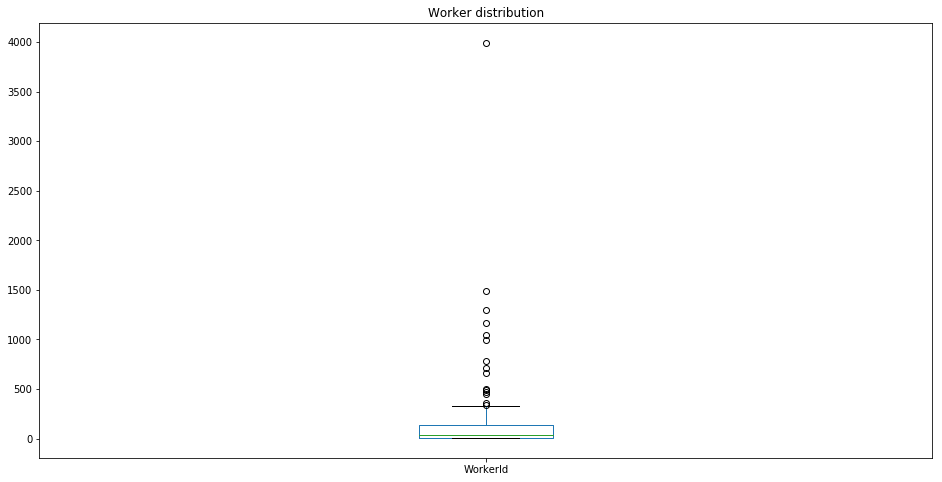

In [22]:
plt.figure(figsize=(16, 8))
df['WorkerId'].value_counts().plot(kind='box')
plt.title("Worker distribution")

Text(0.5,1,'Inputs distribution')

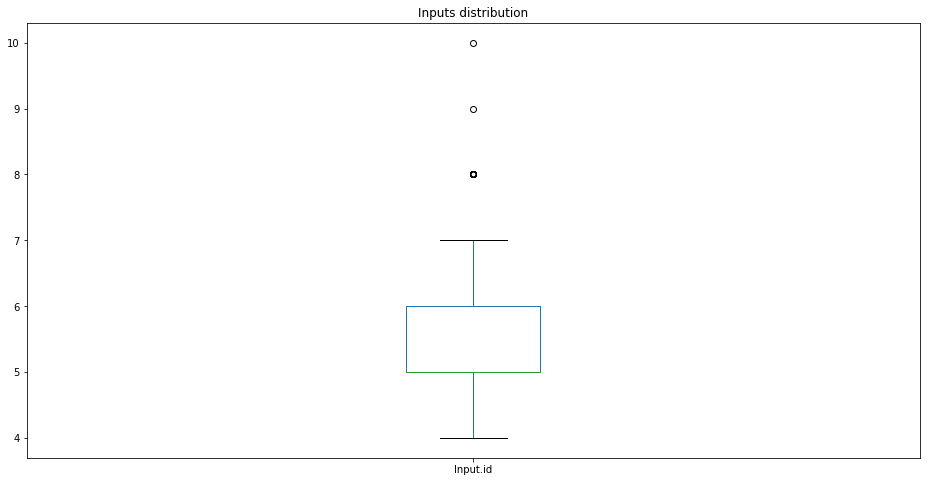

In [23]:
plt.figure(figsize=(16, 8))
df['Input.id'].value_counts().plot(kind='box')
plt.title("Inputs distribution")

Efectivamente hay trabajadores muy atípicos en el set, los usuarios en general hacen entre 30 y 400 clasificaciones, pero hay casos no menores de trabajadores que han hecho miles. Por otro lado se puede ver que los comentarios no son etiquetados por muchas personas, pese a la cantidad de trabajodores la media esta entre 5 y 6 trabajodres en un set de 203.

Dado que no conocemos el valor real de la clase, solo podemos estimar mediante algun tipo de votación entre los participantes que clasificaron cada comentario. La manera más sencilla de realizar esto es por medio de una votación y elegir la clase por mayoría de votos, sin embargo la cantidad de gente que esta votando es considerablemente poca, incluso solo tomando en cuenta la población de trabajadores.

En un intento para mitigar la posible desviación o incluso empates en multiples casos, se ponderara la opinion de cada trabajador basado en un ranking. Este ranking sera basado solo en la cantidad de clasificaciones que ha hecho, dado que existe un número considerable de trabajadores que ha etiquetado mucho más que el usuario promedio su opinión se considerara más valiosa. Asumiremos que estos dos supuestos son verdad: Un trabajador efectivamente puede mejorar su desempeño o ganar experiencia en cuanto más clasifique; Y ningun trabajador esta etiquetando de manera aleatoria.

El ranking se transformara en un puntaje (score) asociado a cada ID del trabajador. Los empates en número de clasificaciones realizadas se traduciran en compartir el rank y por ende score. Dado que existen usuarios que han realizado mil más trabajos que otros no se usara una ponderación directa, si no que con el número asociado al rank se calculara el score como una partición de números del 1.0 al 0.34 equidistante con la cantidad de ranks, es decir:

$$rank_i = \frac{(N_{ranks}- i)\cdot(1.0-0.34)}{(N_{ranks}+1)}$$

Donde i es la posición en el ranking. El intervalo $]0.34,1.0[$ se traduce a que el trabajador con mayor experencias pesa hasta tres veces más en una votación que el de menor experiencia. La razón para utilizar esto es para que en ningun caso un trabajador por su cuenta decida el valor de la etiqueta, esto se cumple ya que el comentario con menor clasificaciones es de cuatro usuarios.

In [33]:
workers_rank = df['WorkerId'].value_counts().rank(method = 'min',ascending=False)
scores = np.arange(0.34,1.0,(1.0-0.34)/159)[::-1]
workers_score=dict()
i=0
for worker,rank in workers_rank.iteritems():
    workers_score[worker] = scores[int(rank)-1]
    i=i+1


In [34]:
inputs = df['Input.id'].unique()
inputs_simple_prediction = dict()
inputs_mayoria_prediction = dict()
inputs_truth = dict()
for inp in inputs:
    df_inp = df[df['Input.id'] == inp]
    rate = 0
    rate_mayoria = 0 
    for index, row in df_inp.iterrows():
        rate = rate + row['Answer.sent']*workers_score[row['WorkerId']]
        rate_mayoria = rate + row['Answer.sent']
    if rate > 0:
        inputs_simple_prediction[inp] = 1
    else:
        inputs_simple_prediction[inp] = -1
    if rate_mayoria > 0:
        inputs_mayoria_prediction[inp] = 1
    else:
        inputs_mayoria_prediction[inp] = -1
        
    inputs_truth[inp] = row['Input.true_sent']

In [35]:
y_simple_pred = list()
y_mayoria_pred = list()
y_true = list()
for key in inputs_truth.keys():
    y_simple_pred.append(inputs_simple_prediction[key])
    y_mayoria_pred.append(inputs_mayoria_prediction[key])
    y_true.append(inputs_truth[key]) 

print('Score predicción simple ponderada: ', round(accuracy_score(y_true=y_true,y_pred=y_simple_pred),4))
print('Score predicción simple mayoría: ', round(accuracy_score(y_true=y_true,y_pred=y_mayoria_pred),4))


Score predicción simple ponderada:  0.884
Score predicción simple mayoría:  0.8696


Antes de comenzar a trabajar con un modelo de aprendizaje automático, se calcula como referencia el valor "máximo" de precisión de solo realizar la votación sin ningun modelo de por medio. Efectivamente la votación ponderada es mejor, no por mucho lamentablemente. Aún así es una mejora y en otro contexto podría tener un gap mayor, pero en este caso no se necesitan trabajodores expertos para etiquetar un comentario como positivo o negativo, de por si solo la exactitud es buena. Se proseguira de todas formas a usar la votación por ponderación ya que sigue siendo estrictamente mejor.

In [39]:
# usar inputs_simple_prediction como label de estimated grounded truth(osea la wea pa entrenar)